In [1]:
import numpy as np
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

%matplotlib inline

### Clustering
Clustering is the process of grouping similar things together. 
Based on the output, there are 2 types of clustering algorithms:<br  >
- <b>flat clustering</b>, where the partitions of objects are disjoint sets<br >
- <b>hierarchical clustering</b>, where the partitions are nested



### 0. Datasets
In this preliminary section, we create several datasets that will be used to illustrate different problems that clustering algorithms face.

In [2]:
centers = [(-5, -5), (0, 0), (5, 5)]
X1, y1 = make_blobs(n_samples = 1000, centers = centers, cluster_std = 1.5)
X2, y2 = make_blobs(n_samples = 1000, centers = centers)
tr = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X2 = np.dot(X2, tr)
X3, y3 = make_blobs(n_samples = 1000, cluster_std = [1.0, 2, 0.5], centers = centers)

X41, y41 = make_blobs(n_samples = 500, centers = [(-5, -5)])
X42, y42 = make_blobs(n_samples = 100, centers = [(0, -5)])
X43, y43 = make_blobs(n_samples = 20, centers = [(0, 0)])
            
X4 = np.concatenate((X41, X42, X43), axis = 0)
y4 = np.array(500 * [0] + 100 * [1] + 20 * [2])

X5, y5 = make_circles(n_samples = 1000, factor=.5, noise = .05)
X6, y6 = make_moons(n_samples = 1000, noise = .05)

X = [(X1, y1), (X2, y2), (X3, y3), (X4, y4), (X5, y5), (X6, y6)]
X_descriptions = ["evenly sized, same isotropic covariance",
                  "evenly sized, same anisotropic covariance",
                  "evenly sized, different isotropic covariance",
                  "unevenly sized, same isotropic covariance",
                  "circles",
                  "moon"]
X_num_clusters = [3, 3, 3, 3, 2, 2]

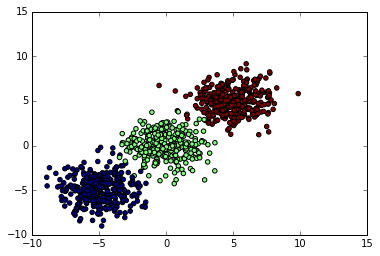

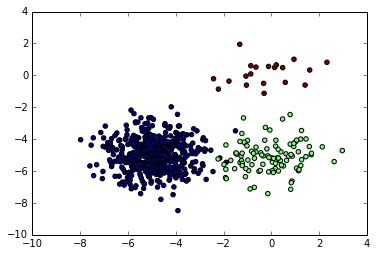

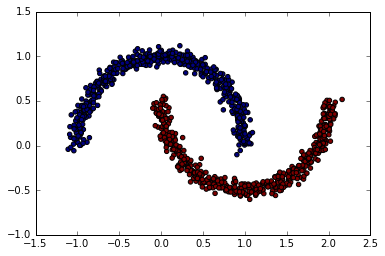

In [3]:
def plot_datasets(X):
    for idx, tup in enumerate(X):
        plt.scatter(tup[0][:, 0], tup[0][:, 1], c = tup[1])
        plt.figure()
plot_datasets(X)

### 1. Flat clustering

   K-Means is a general purpose, distance-based clustering algorithm. It is suitable for very large datasets and it tends to find equal size clusters with flat geometry.
   We plot the K-Means results on the 6 datasets.

In [4]:
#X: [nx2] matrix
#y: labels resulted from clustering
#name: name of the clustering
def plot_results(X, y, name):
    plt.legend(handles = [mpatches.Patch(color='blue', label=name)])
    plt.scatter(X[:, 0], X[:, 1], c = y)
    plt.figure()

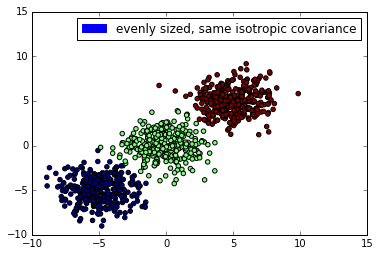

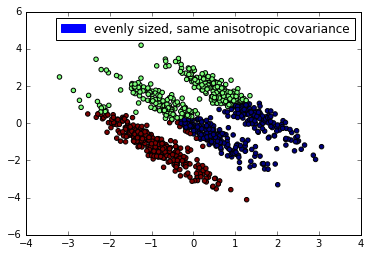

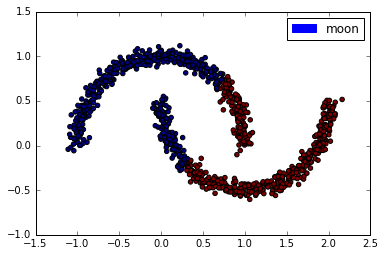

In [21]:
for i in range(6):
    model = KMeans(n_clusters = X_num_clusters[i])
    y = model.fit_predict(X[i][0])
    plot_results(X[i][0], y, X_descriptions[i])

<b>TODO</b>:
1. What clusters does KMeans seem to miss and why?
KMeans especially lacks in predicting concave shapes of objects. Interestingly, anisotropic covariance seem to trick the algorithm into predicting clusters wrong, mainly because it relies solely on the distance from fixed points, and its "Voronoi"-like structure does not model the example well.
2. Try a density-based clustering algorithm (such as DBSCAN). 
3. Try a connectivity-based clustering algorithm (such as Spectral clustering, with different affinities). 
4. Compare the clustering results obtained by the different methods.

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


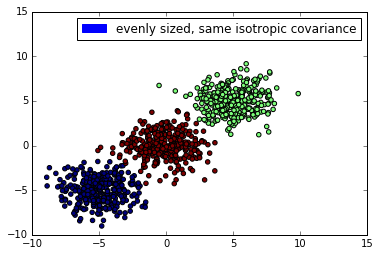

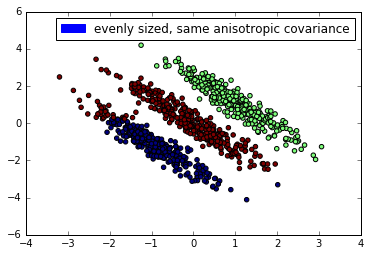

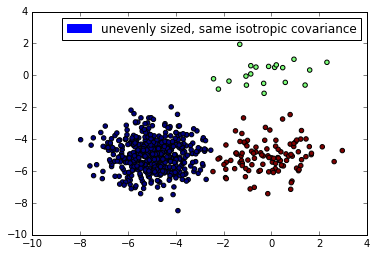

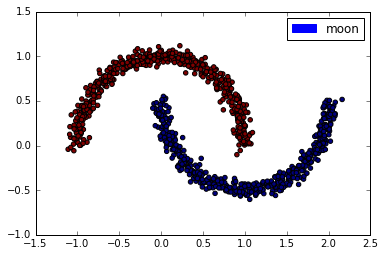

In [10]:
for i in range(6):
    # model = DBSCAN()
    model = SpectralClustering(n_clusters = X_num_clusters[i], affinity = 'nearest_neighbors')
    y = model.fit_predict(X[i][0])
    plot_results(X[i][0], y, X_descriptions[i])

### 2. Hierarchical clustering

Hierarchical clustering has two flavours:
 - Agglomerative: in which each object belongs to a cluster; similar clusters are merged iteratively
 - Divisive: in which all objects belong to the same cluster; at each step, the most cohesive cluster is split

The result is binary-tree like structure called a dendrogram. It shows how the clusters are split/merged at each step:
<img src=http://docs.scipy.org/doc/scipy/reference/_images/scipy-cluster-hierarchy-dendrogram-1_00.png>

If the number of clusters is not known beforehand, it is selected based on the dendrogram.

<b>TODO</b>: Run agglomerative clustering on the previous datasets and try different types of linkages.

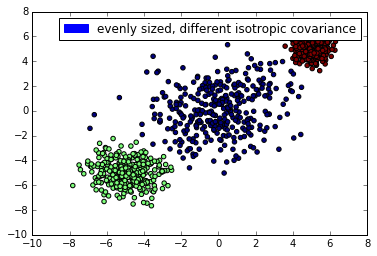

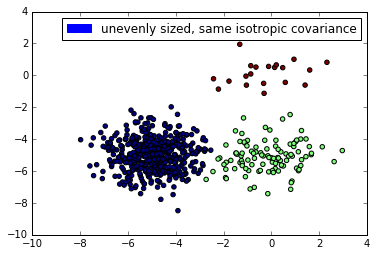

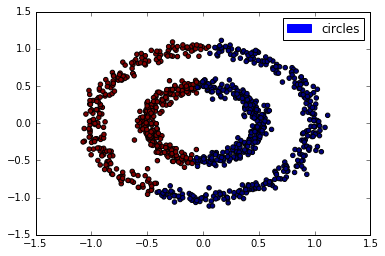

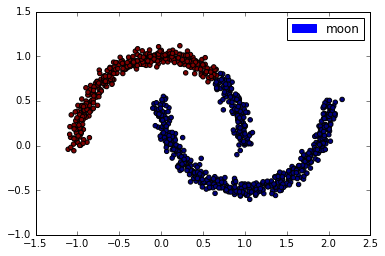

In [20]:
linkages = ['ward', 'complete', 'average']

choose_linkage_index = 0
for i in range(6):
    #TODO
    model = AgglomerativeClustering(linkage = linkages[choose_linkage_index], n_clusters = X_num_clusters[i])
    y = model.fit_predict(X[i][0])
    plot_results(X[i][0], y, X_descriptions[i])

<b>TODO:</b>

How do K-Means and Hierarchical clustering compare regarding:
 - time complexity: Both are iterative algorithms (and pretty fast, to be fair). As tested on my computer, it seems like KMeans converges a tiny bit faster than Hierarchical, but the difference not notable in these examples. It is also worth noting that the examples had ~1000 points, which is a big number compared to the time it to output (~2-3s)
 - prior knowledge of number of clusters: KMeans seems to be at a disadvantage, as it presumes a lot more clusters than hierarchical one
 - shape of clusters: Both seem to lack detecting concave clusters and anisotropic ones

### 3. Evaluate cluster quality
Evaluating cluster quality is not as simple as measuring a classifier's accuracy. Usually, we don't have access to the ground truth, so we can only use the clustering result itself in order to measure the quality of the clusters.

<b>Silhouette score</b> is a measure of how close a sample <b>s</b> is to neighbour clusters versus samples <b>s'</b> from the same cluster as <b>s</b>. 
A value of 1 means a sample is very close to its own cluster and far from other clusters. A value of -1 suggests that a sample is closer to other clusters than to samples from its own cluster.

<b>TODO</b> 
1. Go through tutorial at:
http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py

2. Replot K-Means on the 6 datasets and also compute the average silhouette score on each dataset. Verify that larger scores correspond to a higher quality of clusters. 

0.616863057678
0.386736534892
0.680652871927
0.62838902244
0.353155861047
0.488971514202


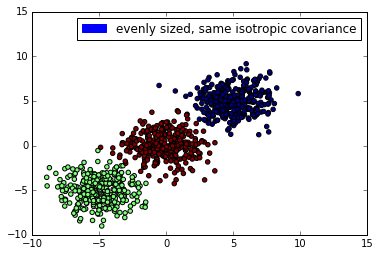

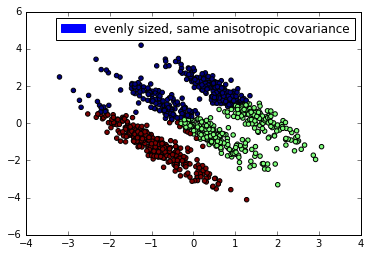

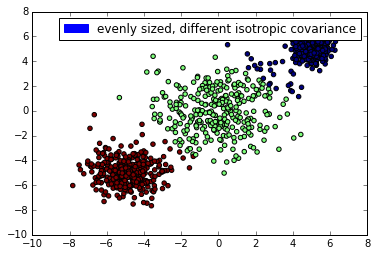

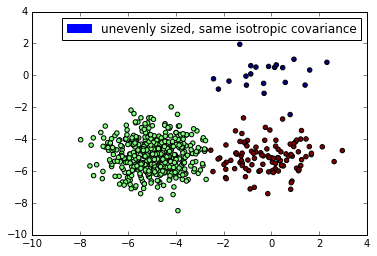

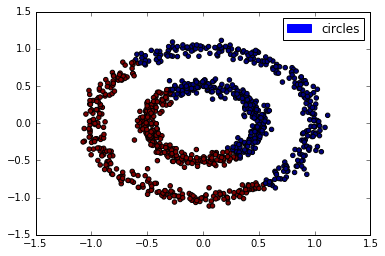

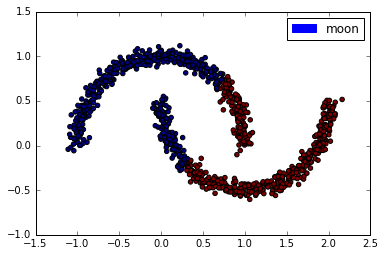

In [23]:
for i in range(6):
    model = KMeans(n_clusters = X_num_clusters[i])
    y = model.fit_predict(X[i][0])
    plot_results(X[i][0], y, X_descriptions[i])
    score = silhouette_score(X[i][0], y)
    print score

Indeed, higher scores correlate graphically with better cluster predictions (examples 1, 3, 4) while lower scores correspond to poor performance (examples 2, 5, 6)

### 4. Practical example: clustering text documents
In this practical example, we're going to do a bit of cluster analysis on text. First we retrieve 4 types of documents. 

In [24]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
dataset = datasets.fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
documents = dataset.data
labels = dataset.target

In [29]:
#TODO: Transform array of documents to a matrix of document-term frequencies, where
#the frequencies are reweighted using the tf-idf criterion (hint: tfidfVectorizer class)
X_freq = TfidfVectorizer().fit_transform(documents)

In [46]:
#TODO: reduce the dimensions of the document-term matrix to 50 dimensions using
#truncated singular value decomposition; scale columns to unit norm
X_svd = TruncatedSVD(n_components=20, random_state=42).fit_transform(X_freq)

for col in range(len(X_svd[0])):
    norm = 0
    for row in range(len(X_svd)):
        norm += X_svd[row][col] ** 2
    norm = np.sqrt(norm)
    
    for row in range(len(X_svd)):
        X_svd[row][col] /= norm

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3387
[t-SNE] Computed conditional probabilities for sample 2000 / 3387
[t-SNE] Computed conditional probabilities for sample 3000 / 3387
[t-SNE] Computed conditional probabilities for sample 3387 / 3387
[t-SNE] Mean sigma: 0.013030
[t-SNE] Iteration 25: error = 1.9808948, gradient norm = 0.0071541
[t-SNE] Iteration 50: error = 1.8758371, gradient norm = 0.0050879
[t-SNE] Iteration 75: error = 1.5154899, gradient norm = 0.0019418
[t-SNE] Iteration 100: error = 1.4498721, gradient norm = 0.0015620
[t-SNE] Error after 100 iterations with early exaggeration: 1.449872
[t-SNE] Iteration 125: error = 1.3519306, gradient norm = 0.0011275
[t-SNE] Iteration 150: error = 1.3228265, gradient norm = 0.0010272
[t-SNE] Iteration 175: error = 1.3156805, gradient norm = 0.0010068
[t-SNE] Iteration 200: error = 1.3137709, gradient norm = 0.0010024
[t-SNE] Iterati

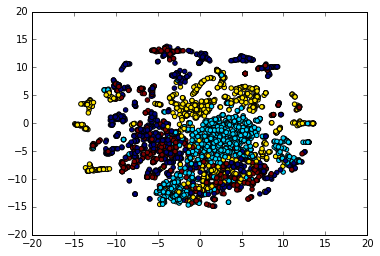

In [48]:
#t-SNE is a tool to visualize high-dimensional data that finds a low-dimensional (2 or 3) embedding of
#the input space.
#We plot the 2-dimensional embedding of the document-term matrix (and use the colors
#corresponding to the true document label)
tsne = TSNE(verbose = 2)
X_tsne = tsne.fit_transform(X_svd)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = labels)
plt.figure()

Notice the shape/spread of the clusters. TSNE is not a clustering method, but the 2D/3D visualisation is helpful in gaining some intuition about the inherent structure of the data and the clustering algorithms that would work
better. 

It can also sometimes serve as an intuition for the approximate number of clusters that we can expect to find. While the TSNE visualization of the previous documents is not particularly helpful in this regard, we can find examples where the examples are well separated in the embedding space:
<img src=http://scikit-learn.org/stable/_images/plot_lle_digits_013.png>

You can check out other TSNE plots here:
https://lvdmaaten.github.io/tsne/

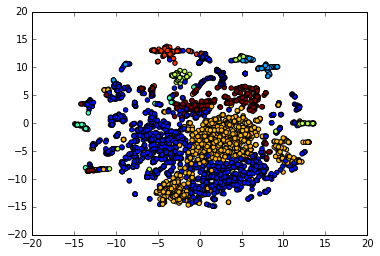

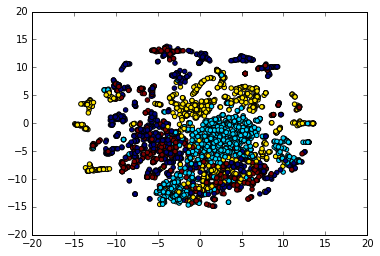

In [50]:
#TODO: apply K-means on the document-term matrix

model = KMeans()
y = model.fit_predict(X_svd)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y)
plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = labels)
plt.figure()


#TODO: plot the 2-dimensional embedding of the documents, but color the points with the labels
#predicted by K-Means. If the clustering is good, the coloring should be similar to the previous plot, 
#where we plotted the real class of each document.

I'm proud of you, KMeans!